<a href="https://colab.research.google.com/github/joseFranciscoDiez/Perikymata-Counter/blob/master/Perikymata_Counter_UBU_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About this code

This code is released using the Google Colab platform. The code is completely free and its modification and distribution is allowed with the only condition of referring to its origin.

The code is written in python but it is not needed any kind of programming knowledge to use it.

Please cite this software as follows:

APA

BibTex

For a tutorial about how to use this code please check the supplementary material. (url: http:\\www.)

**Related projects**

Other colab notebook released by the research team:
1. 
2.

## What is Google Colab

It is a free platform for colaborating and sharing in computer science. It is a cloud service. Reduces barriers to entry due to the need for specific hardware (it uses googles hardware) or software (more common scientific libraries are allready pre-installed)


**Learn more about Google Colab**
https://research.google.com/colaboratory/faq.html


## Using Google Colab

It is based on Jupyter Notebooks. You should execute the cells in order by clicking in button [>] in the left side of the cell or pressing Control + Enter.


# Steps of the processing pipeline

1. Installing software and dependencies.
2. Loading images.
3. Performing the stiching.
4. Automatic perikymata counting
  - Image processing and analysis
  - Parameter Selection
  - Scale and limits selection
  - Stats computation
  



## Installing software and dependencies

Google Colab creates a machine in the cloud for us. This machine is reseted after a few hours of inactivity. The next cell installs software on that machine, it is necessary to run the cell every day that we use this software or if it has not been used for several hours and the machine has been reseted.

---------------


In [1]:
# Installing the software OpenCV and ImageMagic
from IPython.display import clear_output

!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16


!apt-get install imagemagick

!pip uninstall scikit-image -y
!pip install scikit-image==0.14.1

clear_output()

import cv2
import skimage
print("Installed opencv",cv2.__version__)
print("Installed ImageMagick")
print("Installed scikit-image",skimage.__version__)

Installed opencv 3.4.2
Installed ImageMagick
Installed scikit-image 0.14.1


## Definition of functions and auxiliary code

The notebook makes use of functions defined by the developer, which allow the main functionality to be shorter and easier to understand.

A user with programming knowledge can modify and adapt the code without any limitations.

**It is necessary to execute the following cells**.

In [0]:
#@title File Operations Functions (Execute this cell) { display-mode: "form" }


import os
from os.path import join

'''
File operations functions

'''


def look_file(name):
  """Looks for the location of a certain file.
    Parameters
    ----------
    name : str
        Name of the file.
    Returns
    -------
    path : str
        Absolute path of folder that contains the file.
  
  """
  for root, dirs, files in os.walk('/'):
    if name in files:
      return root
    
    
def get_sub_dirs(parent_dir):
  subdirsnames = []
  for dirname, dirnames, filenames in os.walk(parent_dir):
    # print path to all subdirectories first.
    for subdirname in dirnames:
      subdirsnames.append(subdirname)
  return subdirsnames


def show_options(parent_dir, subdirsnames):
  print("Found",len(subdirsnames),"sub-folders in",parent_dir.split("/")[-1])
  for i,subdirname in enumerate(subdirsnames):
    print("enter",i,"to choose",subdirname)
  
    



'''
Auxiliar functions to check and correct the image fragments.

'''

import re
import numpy as np
from os import listdir
from os.path import isfile
from skimage.io import imread, imsave

import subprocess

def execute_command(cmd_lst):
    """
    Execute the external command and get its exitcode, stdout and stderr.
    """
    proc = subprocess.Popen(cmd_lst, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = proc.communicate()
    exitcode = proc.returncode
    
    return exitcode, out, err

def check(inputFolder,filename):
    path = os.path.join(inputFolder, filename)
    img = imread(path)
    img = img.astype(dtype=np.uint8)
    return not img.mean() == 0
  
def get_fixed_name(filename):
    return filename+"_fixed.tif"

def check_correction(inputFolder,filename):
    new_name = get_fixed_name(filename)
    path = os.path.join(inputFolder, filename)
    new_path = os.path.join(inputFolder, new_name)
    
    if os.path.exists(new_path):
        return check(inputFolder,new_name) # chequea la corrección
    else:
        correct(inputFolder,filename) # crea y chequea la corrección
        return check(inputFolder,new_name)
    
    
    
def correct(inputFolder,filename):
        new_name = get_fixed_name(filename)
        path = os.path.join(inputFolder, filename)
        new_path = os.path.join(inputFolder, new_name)
        lst_convert = ["convert",path, "-type","truecolor","-depth","8", new_path]
        execute_command(lst_convert)



def check_all(inputFolder):
    files2stick = []
    all_correct = True
    files = get_input_files(inputFolder)
    for file in files:
        if check(inputFolder,file):
            print(file,"ok")
            files2stick.append(file)
        elif check_correction(inputFolder,file):
            print(file,"erroneo",get_fixed_name(file),"ok")
            files2stick.append(get_fixed_name(file))
        else:
            print(file,"erroneo y no se puede corregir")
            return None
    return files2stick

  
def get_input_files(inputFolder):
    '''
    Get the input files (fragments)
    '''
    files = [f for f in listdir(inputFolder) if isfile(join(inputFolder, f)) and "fixed" not in f]
    num_files = len(files)
    files.sort(key=lambda name: int(re.search('[0-9]+', name).group())) # ordeno por el numero
    return files  
  
  

def get_imgs_to_stitch(inputFolder):
    
    imgs2stick = check_all(inputFolder)
  
    return imgs2stick




In [0]:
#@title Image Operations Functions (Execute this cell) { display-mode: "form" }


def load_images(inputFolder,img_names):
  """Load a list of images from the location specified.
  
    Parameters
    ----------
    inputFolder : str
        Name of the folder that contains the images.
    img_names : list
        A list of image filenames.
        
    Returns
    -------
    path : list
        list of images (numpy array).
  
  """
  
  images = []
  for name in img_names:
    images.append(cv2.imread(join(inputFolder,name)))
  return images




import cv2




def perform_stitching(images, n_retries):
  # create sticher
  stitcher = cv2.createStitcher(False)
  
  #try default
  print("This could take one or more minutes")
  print("Trying default stiching ...")
  output_code,result = stitcher.stitch(images)
  
  
  #try two step mode
  if output_code == 0:
    print("Done.")
    return result
  
  # Crear de nuevo o no, ya veremos
  stitcher = cv2.createStitcher(False)
  
  print("Estimating transform ...")
  output_code = stitcher.estimateTransform( images );
  print("Composing Panorama ...")
  output_code,result = stitcher.composePanorama(np.array([]))
  
  #try multiple times TODO
  if output_code == 0:
    print("Done.")
    return result
  
  print("Stiching have not work, retriying ...")
  
  n = 0
  while not output_code == 0 and n<n_retries:
    print("Retry",n+1,"...")
    stitcher = cv2.createStitcher(False)    
    output_code,result = stitcher.stitch(images)
    
  if not output_code == 0:
    print("Failed, you must stitch the image yourself")
    return None
  
  return result





from scipy.ndimage import convolve

from skimage import io
from skimage.color import grey2rgb
from skimage.color import rgb2gray
from skimage.draw import line, circle
from skimage.exposure import equalize_adapthist
from skimage.filters import threshold_adaptive
from skimage.morphology import skeletonize_3d, remove_small_objects
from skimage.restoration import denoise_tv_chambolle
from skimage.transform import probabilistic_hough_line





def preprocess_img(img, denoiseWeigh=0.5, clip_limit=0.0, nbins=100):
  
  denoiseWeigh = denoiseWeigh
  clip_limit=clip_limit
  nbins=nbins

  
  # kernelG8
  kernel_NE = np.array([[-3, 5, 5],
                        [-3, 0, 5],
                        [-3, -3, -3]],dtype=np.float32)



  # Conversión de la imagen a escala de grises
  imgGray = rgb2gray(img)
  print("Convert to gray")

  # Ecualización adaptativa del histograma 
  imgAdapted = equalize_adapthist(imgGray, clip_limit=clip_limit, nbins=nbins)
  print("equalize")

  # Eliminación del ruido de la imagen
  imgDenoise = denoise_tv_chambolle(imgAdapted, weight=denoiseWeigh)
  print("Denoise")

  # Convolución, detección de bordes
  imgConvolve = convolve(imgDenoise, kernel_NE)
  print("Edge Detection")
  
  return imgConvolve




def extract_small_region(img, row_min,row_max, column_min, colum_max):
  

  img_crop = None
  if row_min<0 or column_min<0:
    print("row_min and column_min should be more than 0")
  elif row_min>=row_max or column_min>=colum_max:
    print("row_max and colum_max should be bigger than row_min or column_min, respectively")
  elif row_max>img.shape[0] or colum_max>img.shape[1]:
    print("row_min and column_min should be less than size of the image")
    print("the img is",img.shape[0],"x",img.shape[1])
  else:      
    img_crop = img[row_min:row_max,column_min:colum_max].copy()

  return img_crop


def get_profiles(img,row_indexes):

  profiles = []


  for i in row_indexes:
    profile = []

    for j in range(len(img[i])):    
      profile.append(img[i,j])

    profiles.append(profile)
  
  return profiles
  
  
  
from scipy.signal import find_peaks
  
  
def get_peaks(profiles, distance=10, prominence = 0.4):
  all_peaks = []
  
  for profile in profiles:
    peaks, _ = find_peaks(np.array(profile), 
                        distance=distance, 
                        prominence=prominence)
    all_peaks.append(peaks)
    
  return all_peaks




from scipy import stats




def heuristic_peaks_score(peaks, width, proportiontocut=0.1, dup_thres=0.5):
    """Calculate a heuristic score of how good a set of peaks is. 
    
    Evaluates:
    - the distance between peaks is uniform.
    - No duplicate peaks (the distance between two consecutive peaks is too low).
    - That peaks have not been missed (the distance between two consecutive peaks is too high).
  
    Parameters
    ----------
    peaks : array
        A numpy array with the location of the peaks
    
    width: int
        width of the image
        
    proportiontocut : double
        Fraction to cut off of both tails of the distribution. Used to compute the
        trimmed mean of distances between peaks
        
    dup_thres: double
        Value used to calculate the minimum distance between peaks, 
        so that a certain peak is not considered a duplicate or false positive.

        For example: 0.5 means that if a peak is less than 0.5 mean_distance it is an error.
        
    Returns
    -------
    score : double
        heuristic score of how good a set of peaks is.
        Bigger is better
  
    """
  
    peaks_arr = peaks.copy()
    peaks_arr.sort()
    distances = np.diff(peaks_arr)
    trim_mean = stats.trim_mean(distances, proportiontocut)
    
    # número de picos
    n_peaks = len(peaks)
    
    # diferencia con la distancia media entre picos
    difference_trim_mean = (distances - trim_mean).mean()/ trim_mean
    difference_trim_mean = abs(difference_trim_mean)
    
    # probabilidad de que haya picos contados de más
    dup_prob = (distances < (trim_mean * dup_thres)).mean()
    
    # número de picos no duplicados
    valid_num = (distances > (trim_mean * dup_thres)).sum()
    
    # probabilidad de que haya picos perdidos
    miss_prob =  1 - ((trim_mean * valid_num) / width)      
        
    return (n_peaks / (dup_prob + miss_prob) / (difference_trim_mean+1))
                


    
def find_best_row(y_min,y_max,imgConvolve, proportiontocut = 0.1, dup_thres = 0.5):
  
  # find peaks in each row of the image
  all_peaks = list(map(lambda row : find_peaks(row, distance=distance, prominence=prominence)[0],  imgConvolve))

  # apply the score computation to all rows of the image
  scores = list(map(lambda peak: heuristic_peaks_score(peak,imgConvolve.shape[1], proportiontocut, dup_thres), all_peaks))
  
  # sort rows according the scores
  best_rows = np.argsort(np.array(scores))

  # Filter the rows to select
  best_rows=best_rows[np.where( (best_rows > y_min) &  (best_rows < y_max))] 
  
  return best_rows[-1]




from skimage.transform import rescale

# get an image that shows the root and crown of the tooth in detail 
def create_detail_img(img):
  img_mini = rescale(img,0.2)
  n = int(img_mini.shape[1]/3)
  por_ini = list(range(n))
  por_fin = list(range(img_mini.shape[1]-n,img_mini.shape[1]))

  img_detail = img_mini[:,
                       por_ini+por_fin].copy()
  img_detail = grey2rgb(img_detail)
  
  return img_detail


def get_tooth_parameters(img,root_ini,crown_ini):
  root_ini_val = (root_ini/50)*(img.shape[1]/3)
  crown_ini_val = ((crown_ini-50)/50)*(img.shape[1]/3)+(img.shape[1]*(2/3))

  size_in_pixels = crown_ini_val-root_ini_val
  
  return root_ini_val, crown_ini_val, size_in_pixels
  

  
from skimage.filters import threshold_otsu, threshold_local
from skimage.morphology import remove_small_objects
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
  
def find_scale_line(img):
  
  block_size = 35


  local_thresh = threshold_local(img, block_size, offset=-0.1)
  binary_local = img > local_thresh
  imgRemoveSmall = remove_small_objects(binary_local, 200)



  lines = probabilistic_hough_line(imgRemoveSmall, threshold=50, line_length=150,line_gap=10)


  x_min = img.shape[0]
  x_max = 0
  y = 0
  
  if len(lines)>0:
    y = lines[0][1][1]
    for seg in lines:
        if seg[0][0]<x_min:
            x_min = seg[0][0]
        if seg[1][0]>x_max:
            x_max = seg[1][0]


  return x_max,x_min,y




def perikymata_stats(peaks, proportiontocut,correction_factor):
  """Obtain stats from a list of peaks.
    Parameters
    ----------
    peaks : list
        List of Peaks.
        
    proportiontocut: Double
        Fraction to cut off of both tails of the distribution
        
    Returns
    -------
    rango : Double
        Distance Between first and last peak.
    num: Integer
        Number of peaks.
        
    mean_dist : Double
        Mean of the distances between peaks.
        
    trim_mean_dist : Double
        Trimmed Mean of the distances between peaks.
        
  
  """
  proportiontocut = 0.1
  root_index, crown_index
  
  
  num = len(peaks)
  distances = np.diff(peaks)
  mean_dist = distances.mean()*correction_factor
  trim_mean_dist = stats.trim_mean(distances, proportiontocut)*correction_factor
  return num, mean_dist, trim_mean_dist


def perikymata_bins_stats(peaks,num_bins,root_index, crown_index, proportiontocut,correction_factor):
  
  # divides the space between the root and the crown in equal parts
  bin_edges = np.linspace(root_index,crown_index,num_bins+1)
  
  
  
  stats = []
  
  
  for i in range(num_bins):
    indexes = np.where((peaks>=bin_edges[i]) & 
                       (peaks<=bin_edges[i+1]))[0]
    values = peaks[indexes]
    stats.append(perikymata_stats(values,proportiontocut,correction_factor))
        
  return np.array(stats)

In [0]:
#@title Image Visualization and User Interaction Functions (Execute this cell) { display-mode: "form" }

import matplotlib.pyplot as plt
from math import floor,ceil



def show_image(img,figsize=(20,20)):
  plt.figure(figsize=(20,20))
  plt.grid(False)  
  plt.imshow(img)


def show_multiple_images(images):

  n = len(images)


  n_rows = ceil(n**0.5)
  n_cols = floor(n/n_rows)

  if n>n_rows*n_cols:
    n_rows+=1
  n,n_rows,n_cols


  f, axs = plt.subplots(n_rows, n_cols, 
                        sharex='col', 
                        sharey='row', figsize=(n_cols*8,n_rows*8))

  i = 0
  for axs_rows in axs:
    for ax in axs_rows:
      if i<n:
        ax.grid(False) 
        ax.set_title(i)
        ax.imshow(images[i])
        i+=1
        
        

def show_peak_detection_test(img,img_edges,test_rows,profiles,peaks,figsize=(10, 10)):


  fig, ax = plt.subplots(len(profiles)+2,1,figsize=(10, 10))
  ax[0].grid(False)  
  ax[1].grid(False)  

  # normalize edge image
  img_edges_norm = (img_edges - np.min(img_edges))/np.ptp(img_edges)
  
  img_test = img.copy()
  

  for i in range(len(profiles)):
    profile = np.array(profiles[i])
    peaks_i = peaks[i]
  
 
  
    ax[i+2].grid(False)  
    ax[i+2].plot(peaks_i, profile[peaks_i], "X")
    ax[i+2].plot(profile)
    ax[i+2].plot(np.zeros_like(profile), "--", color="gray")
  
  
    for p in peaks_i:
      rr, cc = circle(test_rows[i], p, 3)
      img_test[rr, cc] = [255,0,0]
    

  
  
  ax[0].imshow(img_test)  
  ax[1].imshow(img_edges_norm)
  
  
  
  
  
def show_peak_detection(img,imgConvolve,row_index,figsize=(15, 10)):



  img_test = img.copy()

  fig, ax = plt.subplots(2,1,figsize=(15, 10))
  ax[0].grid(False)  
  ax[1].grid(False)  



  profile = imgConvolve[row_index,:]
  peaks = find_peaks(profile, distance=distance, prominence=prominence)[0]



  ax[1].plot(peaks, profile[peaks], "X")
  ax[1].plot(profile)
  ax[1].plot(np.zeros_like(profile), "--", color="gray")


  for p in peaks:
    rr, cc = circle(row_index, p, 3)
    img_test[rr, cc] = [255,0,0]




  ax[0].imshow(img_test) 
  
  
  
def show_crop_scale(img,scale_location):

  imgGray = img.copy()
  height, width = 0,0
  
  if img.ndim==2:
    height, width = img.shape
  else:
    height, width, channels = img.shape

  if not orientation == 1:
    imgGray = imgGray[:, ::-1].copy()


  if scale_location == "A":
    scale_crop = imgGray[:int(height/2),
                         :int(width/2)].copy()
  elif scale_location == "B":
    scale_crop = imgGray[:int(height/2),
                         int(width/2):].copy()
  elif scale_location == "C":
    scale_crop = imgGray[int(height/2):,
                         :int(width/2)].copy()
  else:
    scale_crop = imgGray[int(height/2):,
                         int(width/2):].copy()



  plt.figure(figsize=(10,10))
  plt.grid(False)  
  plt.imshow(scale_crop,cmap="gray")
  
  return scale_crop  



def show_root_crown(img,root_index,crown_index):


  plt.figure(figsize=(10,10))
  plt.grid(False)  
  plt.imshow(img,cmap="gray")


  plt.plot([root_index,root_index], 
           [0,img.shape[0]], '--', linewidth=2, color='firebrick')
  plt.plot([crown_index,crown_index], 
           [0,img.shape[0]], '--', linewidth=2, color='firebrick')
  
  
  
def show_results(img,peaks,row_index, num_bins,root_index,
                 crown_index,correction_factor,
                 label_x_offset,label_y_offset,figsize=(20,20)):
  
  img_test = img.copy()
  
  fig = plt.figure(figsize=figsize)
  plt.grid(False)  
  plt.imshow(img,cmap="gray")


  plt.plot([root_index,root_index], 
           [0,img.shape[0]], '--', linewidth=2, color='firebrick')
  plt.plot([crown_index,crown_index], 
           [0,img.shape[0]], '--', linewidth=2, color='firebrick')
  
  
  bin_edges = np.linspace(root_index,crown_index,num_bins+1)
  for i in range(1,num_bins):
    # draw vertical line
    plt.plot([bin_edges[i],bin_edges[i]], 
             [0,img.shape[0]], '-', linewidth=1, color='royalblue')
    
  for i in range(num_bins):
    #draw text
    plt.text(bin_edges[i]+label_x_offset, 
             row_index+label_y_offset, 
             "D"+str(i+1), fontsize=12, color = 'orange')
    
    
  for p in peaks:
    rr, cc = circle(row_index, p, 3)
    img_test[rr, cc] = [255,0,0]




  plt.imshow(img_test)  
  fig.savefig('Results.pdf')

  
        
        
'''
User interface functions

'''

'''
this code looks for the folder that contains "perikymata_img_bookmark.txt".

Ask user the tooth to be analyzed
'''

def ask_image_folder(img_dir):
  
  inputFolder = None   

  if isinstance(img_dir, str):
    print("Image Fragment found in folder ",img_dir.split("/")[-1])
    subdirsnames = get_sub_dirs(img_dir)

    show_options(img_dir, subdirsnames)
    index = int(input("Choose a sub-folder (enter a number and press enter) "))
    if index in range(len(subdirsnames)):
      img_fragments_dir = subdirsnames[index]
      inputFolder = join(img_dir,img_fragments_dir)
      print(img_fragments_dir, "was selected")
    else:
      print("You chose an incorrect number Re-execute the cell")
  else:
    print("""perikymata_img_bookmark.txt was not found, 
             please review the instructions.""")
  
  return inputFolder



from google.colab import files

# Mueve esto a funciones de interacción con el usuario
def ask_if_ok():
  img = result.copy()
  response = input("It is the imagen ok for you? [Y]es / [N]o, i will upload my own panorama\n")
  if response == "Y":
    print("Ok, continue")
  elif response == "N":
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    uploaded = list(uploaded.keys())[0]
    print(uploaded)
    img = cv2.imread(uploaded)

    
    show_image(img)
  else:
    print("Please type Y or N (case sensitive)")
    
  return img




def select_peaks(img,y_min,y_max,proportiontocut=0.1, dup_thres = 0.5):
  
  best_row = 0
  
  option = input("""Choose the row where peaks will be counted.
                 -[H] Try [H]euristic search of the best row
                 -[M] Select the row [M]anually
                 """)
  if option == "H":
    best_row = find_best_row(y_min,y_max,img)
    print("The best row between",y_min,"and",y_max,"is",best_row)
    print("It is possible to limit the beginning and end of the tooth later")
  elif option == "M":
    best_row = int(input("Type an integer with your selection "))
    if best_row > img.shape[0] or best_row<0:
      print("Retry and choose a row within the limits of the image")
  else:
    print("Please, type H or M")
    
  return best_row



def show_crow_root_selection(img,root_ini,crown_ini):

  print('You selected', root_ini, crown_ini)


  r_percentile = root_ini
  c_percentile = crown_ini
  root = int(img.shape[1]*r_percentile/100)
  crown = int(img.shape[1]*c_percentile/100)


  plt.figure(figsize=(10,10))
  plt.grid(False)  
  plt.imshow(img)
  plt.plot([root,root], [0,img.shape[0]], '-', linewidth=2, color='firebrick')
  plt.plot([crown,crown], [0,img.shape[0]], '-', linewidth=2, color='firebrick')
  
  
  
  from matplotlib.pyplot import show


def try_automatic_scale_selection(img):

  retry = True
  sucess = False

  img_scale = rgb2gray(img)


  while retry:
    x_max,x_min,y = find_scale_line(img_scale)

    clear_output()
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.grid(False)  
    ax.imshow(img_scale,cmap="gray")
    ax.plot((x_min, x_max), (y, y))

    show()


    option = input("It is correct for you:\n [Y]es \n [N]o, retry \n [S]top, I'll select the scale manually\n")
    if option == 'Y':
      retry = False
      sucess = True
    elif option == 'S':
      retry = False
      sucess = False
      
      
  return x_max,x_min,sucess



def show_scale(img,scale_ini,size):

  scale_x1 = int(scale_crop.shape[1]*(scale_ini/100))
  scale_x2 = int(scale_x1+scale_crop.shape[1]*(size/100))

  plt.figure(figsize=(10,10))
  plt.grid(False)  
  plt.imshow(scale_crop,cmap="gray")
  plt.plot([scale_x1,scale_x1], [0,scale_crop.shape[0]], '-', linewidth=1, color='firebrick')
  plt.plot([scale_x2,scale_x2], [0,scale_crop.shape[0]], '-', linewidth=1, color='firebrick')
  
  return scale_x2, scale_x1

## Loading the images.

1. Upload your images to your google drive. Check the images guidelines in the supplementary material (url:   http:\\wwww.) Skip this step if you already have uploaded the images.
2. Upload a file called 'perikymata_img_bookmark.txt' to indicate the folder where the images should be searched. This file should be at the same level than the tooth folders.  Skip this step if you already have uploaded the file. 
3. Grant permission for google colab to mount google drive and load images of teeth

In [0]:
from google.colab import drive
# mount google drive in /content/drive in the colab disc.

drive.mount('/content/gdrive')
clear_output()
img_dir = None

### Select the set of images to process

The following code searches for the folder with the images of the teeth in the Google Drive.
The root folder where the folders with the teeth are located should contain a file called "perikymata_img_bookmark.txt"
All of the image fragments should be in the same sub-folder. Only one of the fragments should have the reference scale.

Run the following cell:
- choose a folder of images and press enter.
- then the code will check all the images for any error. 
- Finally it will load and show the images.

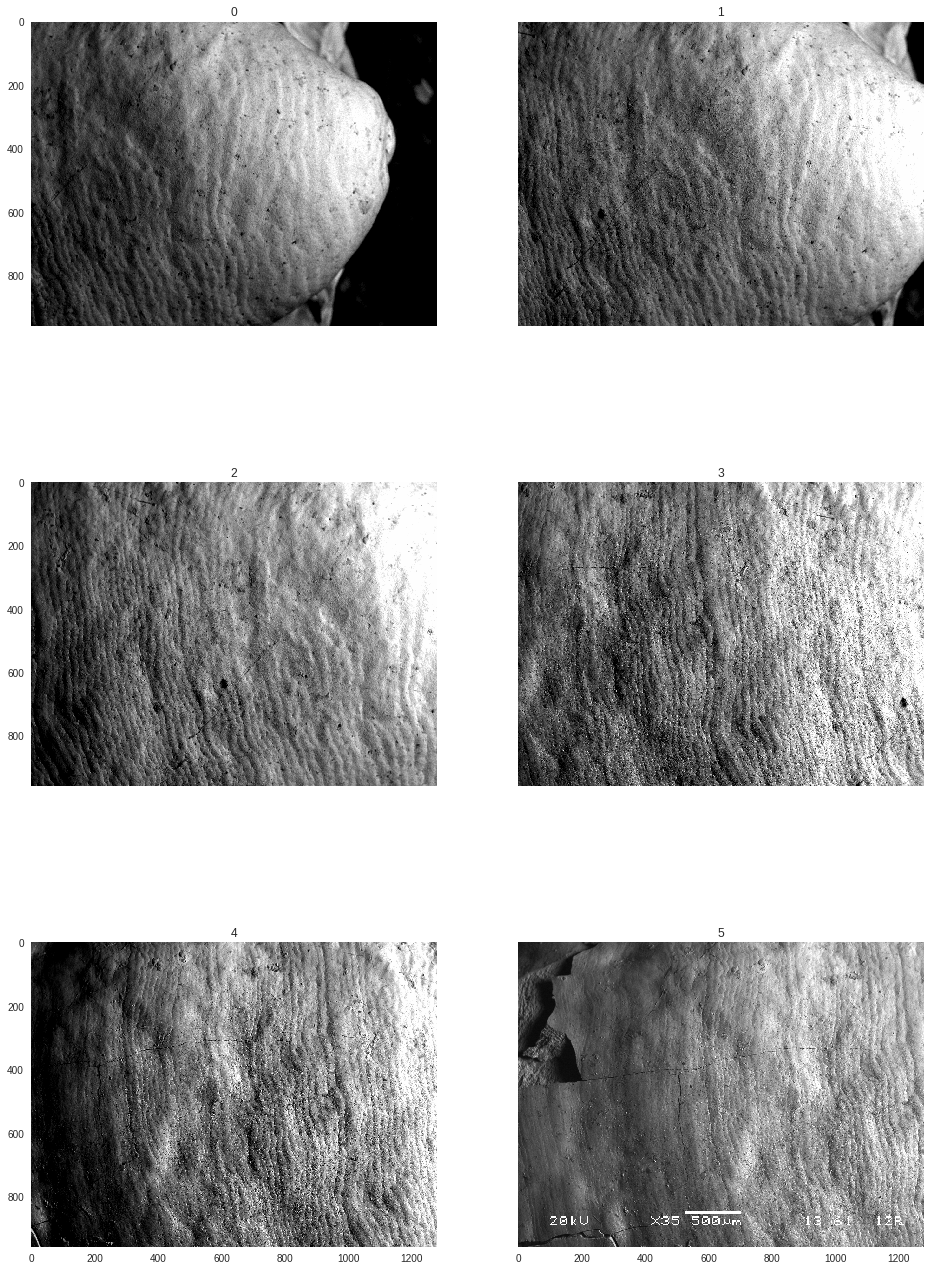

In [18]:
bookmark = "perikymata_img_bookmark.txt"

if img_dir is None:
  img_dir = look_file(bookmark)
  
inputFolder = ask_image_folder(img_dir)
images = []

if not inputFolder is None:
  print("Checking images")
  img_names = get_imgs_to_stitch(inputFolder)
  clear_output()

  images = load_images(inputFolder,img_names)
  show_multiple_images(images)
else:
  print("You can't continue")
  

In [0]:
scale_index = int(input("Type de number of the image with the scale (is on the top of the image)\n"))
# the image fragment with the scale is added to prevent it from being lost in the stiching process
images+=[images[scale_index]]

Type de number of the image with the scale
5


## Performing the stiching.

Execute the following cell to perform the stiching.

If the stiching is correct or the program is unable to perform the stiching correctly after several tries, continue with the execution.
If the program is unable to perform the stiching you can upload a manually stiching image

In [0]:
# Perform stitching
num_retries = 5
result = perform_stitching(images, num_retries)
img = result.copy()




This could take one or more minutes
Trying default stiching ...
Done.


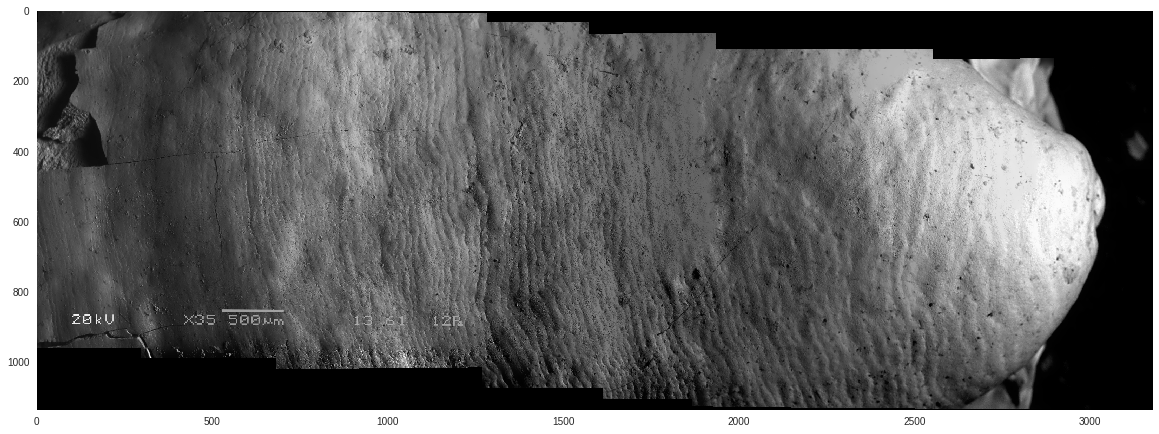

In [0]:
# Show the composition
show_image(result)

### Download the panorama image.

The following cell download the panorama image.

Execute the following cell if you want to download the composition.

In [0]:
# Download the panorama image (if you want)
from google.colab import files


output_file = "output.tiff"
cv2.imwrite(output_file, result)

files.download(output_file)

Execute the following cell. The program will ask if the image is correct or if you want to upload your own panorama, In case the program can not create a panoramic image of satisfactory quality.

In [0]:
img = ask_if_ok()

It is the imagen ok for you? [Y]es / [N]o, i will upload my own panorama
Y
Ok, continue


## Automatic Image Processing

The program is going to:
- Enhance de image quallity:
  - Equalization
  - Denoising
- Find vertical edges (perikymata) using Kirsh operator

- Let choose parameter for the peak finder (peak of perikymata).
- Apply the peak finder to the whole image.
- Estimate the best row, in the image according to certain heurístics



In [0]:
import warnings
warnings.filterwarnings("ignore")

imgConvolve = preprocess_img(img)

Convert to gray
equalize
Denoise
Edge Detection


### Selection of parameters

Next, a small section of the image is extracted.

It will be used to adjust the parameters of the perikymata counting method.

Please, select the small section of the image using the numbers in the axis in the composition figure.

You will use this fragment for parameter testing


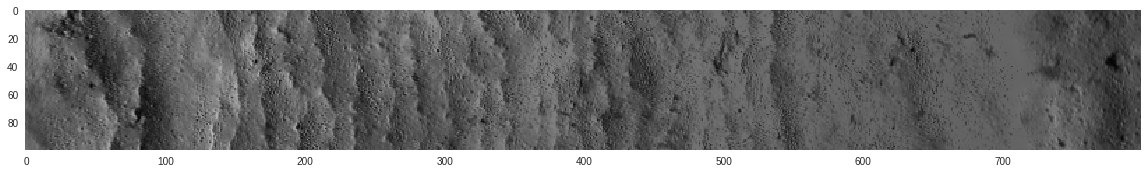

In [0]:
'''
Check and change this parameters, depends on each image
'''


row_min = 500 
row_max = 600

column_min = 1200
colum_max = 2000

######

imgConvolve_crop,test_rows = None, None

img_crop = extract_small_region(img, row_min, row_max, column_min, colum_max)
if not img_crop is None:
  show_image(img_crop)
  print("You will use this fragment for parameter testing")
  
  # Extract a small region, to test de parameters of the peak (perikymata) detection
  imgConvolve_crop = extract_small_region(imgConvolve, row_min, row_max, column_min, colum_max)

  # get 3 equidistant lines
  # peaks are going to be detected in these 3 lines
  test_rows = np.linspace(0, row_max-row_min, 5).astype(int)[1:-1]

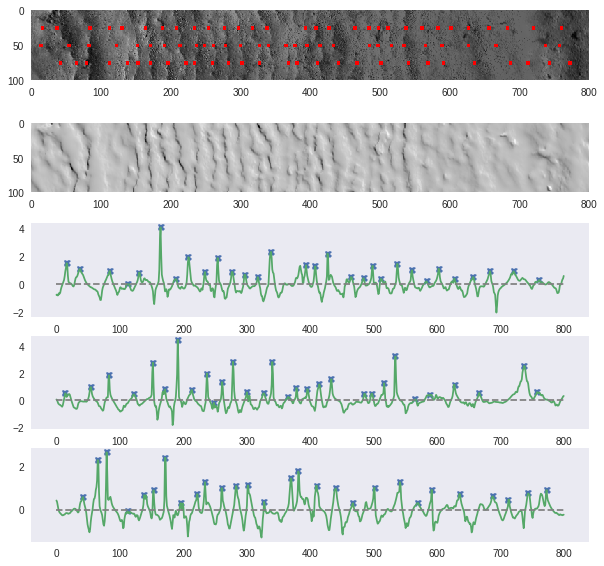

In [0]:
# Parameters to adjust
prominence = 0.4 #Default 0.4
distance=10      #Default 10


profiles = get_profiles(imgConvolve_crop,test_rows)
peaks = get_peaks(profiles, distance=10, prominence = 0.4)  

show_peak_detection_test(img_crop,imgConvolve_crop,test_rows,profiles,peaks,figsize=(10, 10))



Choose the row where peaks are counted.
                 -[H] Try [H]euristic search of the best row
                 -[M] Select the row [M]anually
                 H
The best row between 400 and 600 is 408
It is possible to limit the beginning and end of the tooth later


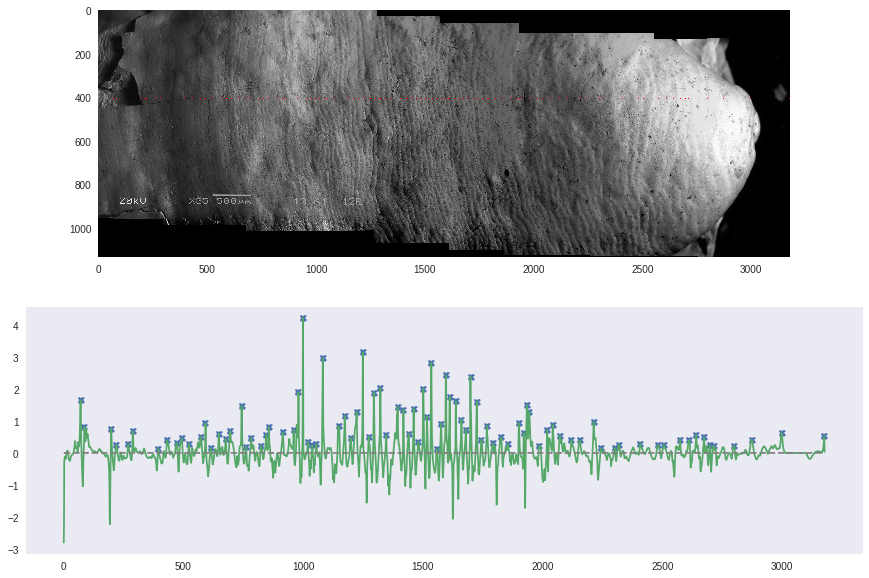

In [0]:

y_min = 400
y_max = 600   

  
best_row = select_peaks(imgConvolve,y_min,y_max)
peaks = find_peaks(imgConvolve[best_row], distance=distance, prominence=prominence)[0]

if not best_row==0:
  show_peak_detection(img,imgConvolve,best_row)

### Estimate the scale of the image and its orientation

Halla la escala y la orientación del diente, pide corregirla si no está bien.


What orientation has the tooth:
 1 - Root -- Crown 
 2 - Crown -- Root 
 1
Where is the scale: 
 A|B 
 C|D 
C


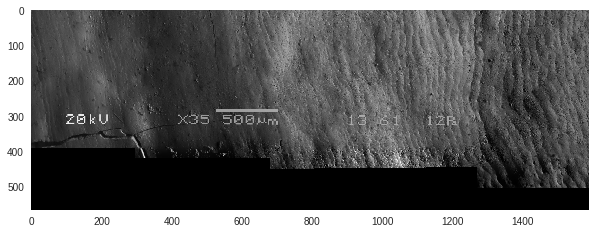

In [0]:
orientation = int(input("What orientation has the tooth:\n 1 - Root -- Crown \n 2 - Crown -- Root \n "))
scale_location = input("Where is the scale: \n A|B \n C|D \n")

scale_crop = show_crop_scale(img,scale_location)
#TODO orientation is not used


In [0]:


img_detail = create_detail_img(img)




You selected 14.0 93.5


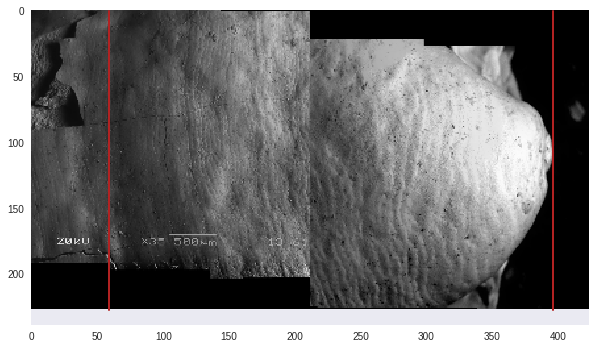

In [0]:
#@title Adjust the beginning of the root and end of the crown of the tooth  { run: "auto" }

root_ini = 14.0 #@param {type:"slider", min:0, max:50, step:0.5}
crown_ini = 93.5 #@param {type:"slider", min:50, max:100, step:0.5}

show_crow_root_selection(img_detail,root_ini,crown_ini)


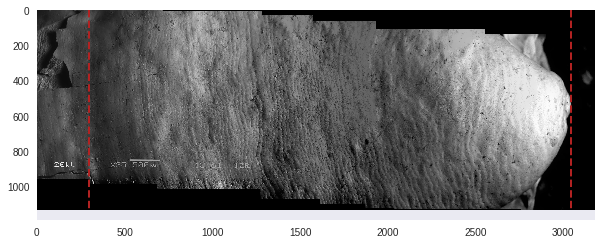

In [0]:
root_index,crown_index,size_in_pixels= get_tooth_parameters(img,root_ini,crown_ini)
show_root_crown(img,root_index,crown_index)

The following cell try to estimate the scale of the image.

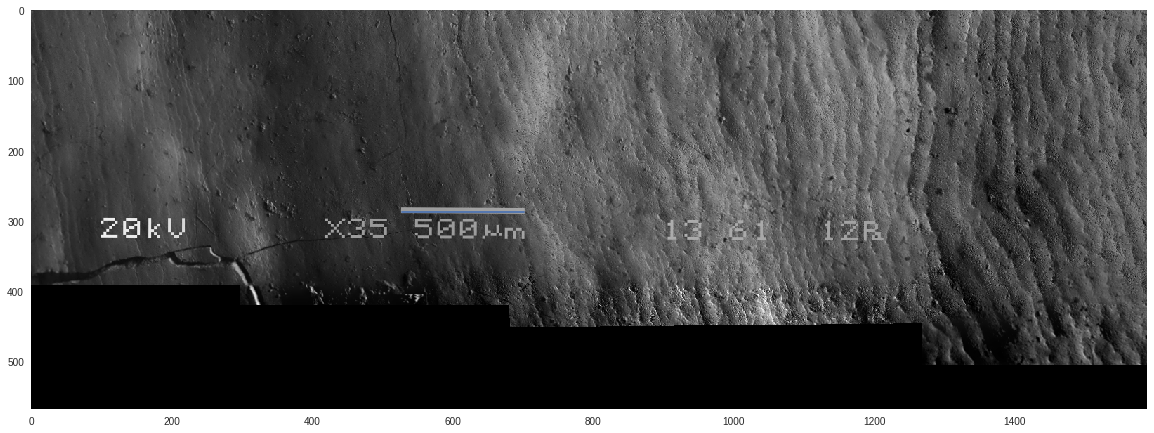

It is correct for you:
 [Y]es 
 [N]o, retry 
 [S]top, I'll select the scale manually
Y


In [0]:
 x_max,x_min,sucess = try_automatic_scale_selection(scale_crop)
  

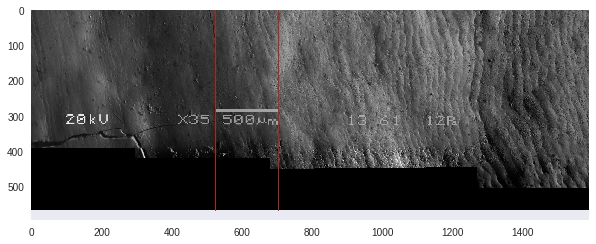

In [0]:
#@title Adjust the parameters of the scale if needed  { run: "auto" }

scale_ini = 33 #@param {type:"slider", min:0, max:100, step:0.1}
size = 11.3 #@param {type:"slider", min:0, max:100, step:0.1}


if not sucess:
  x_max,x_min = show_scale(scale_crop,scale_ini,size)



In [0]:
#@title Select the units of the scale  { run: "auto" }

value = 500 #@param {type:"slider", min:0, max:1000, step:50}
unit = "Micrometres" #@param ["Nanometres", "Micrometres", "Milimetres"] 

scale_size = x_max-x_min
correction_factor = value/scale_size

print(scale_size,"pixels are",value,unit)


179 pixels are 500 Micrometres


In [0]:
proportiontocut = 0.1
num_partitions = 10


peaks_filtered = peaks[(peaks>root_index) & (peaks<crown_index)]

p_bin_stats = perikymata_bins_stats(peaks_filtered,num_partitions,
                                    root_index, crown_index,
                                    proportiontocut,correction_factor)
p_stats = perikymata_stats(peaks, proportiontocut,correction_factor)
    
  



import pandas as pd
columns=["Number","Mean Distance","Trimmed Mean Distance"]
index = ["Decile"+str(i) for i in range(1,11)]

df_total = pd.DataFrame(np.array([p_stats]),columns=columns, index=["Total"])

df_deciles =  pd.DataFrame(p_bin_stats,columns=columns, index = index)

df_total

Number  Mean Distance  Trimmed Mean Distance
Total    82.0      89.764811              79.415557

In [0]:
df_deciles

Number  Mean Distance  Trimmed Mean Distance
Decile1      5.0      89.385475              89.385475
Decile2     11.0      76.256983              72.276536
Decile3      9.0      78.561453              78.561453
Decile4     10.0      75.729361              75.729361
Decile5     13.0      56.331471              56.145251
Decile6     11.0      71.229050              68.086592
Decile7      8.0     107.342378             107.342378
Decile8      5.0     165.502793             165.502793
Decile9      7.0      96.834264              96.834264
Decile10     3.0     277.932961             277.932961

Root start in pixel 296 crown ends in  3041
Size  7666.303538175044 Micrometres


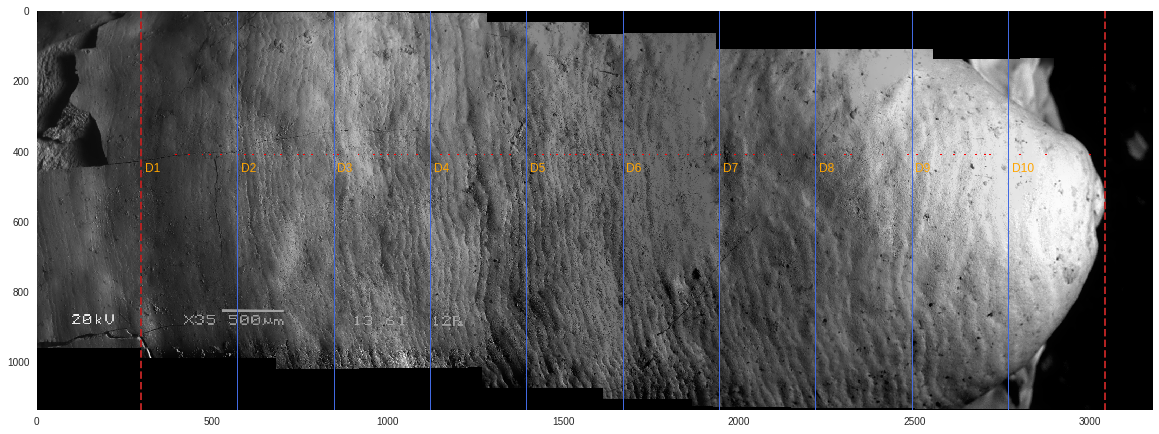

In [0]:
print("Root start in pixel",int(root_index),"crown ends in ",int(crown_index))
print("Size ",(crown_index - root_index) * correction_factor,unit)
show_results(img,peaks_filtered,best_row, num_partitions,
             root_index, crown_index,correction_factor,
             10,50,figsize=(20,20))

In [0]:
from google.colab import files


# Download the results image
files.download('Results.pdf')


# Next Ideas:
- Different parameters for each decile
- Hypoplasia: the thickest and deepest lines
- Automatic detection of the tip of the tooth.




